# HW02 -- NeuralNetwork 葡萄酒分類

In [1]:
import csv
import math
import random
import operator
import sys
import matplotlib.pyplot as plt
import numpy as np
import time

random.seed()

## 開啟資料檔 ##

利用 Python With open as 語法開啟 wine.data，避免忘記關檔發生錯誤。開啟資料的同時也對資料進行以下幾項處理：
1. 進行標準化
1. 欄位轉置
1. 打亂訓練資料

### **進行標準化** ###

原始資料並未進行標準化，最後的計算結果可能會受到某些數值較大的欄位嚴重影響，因此利用下列公式進行標準化：

*(X - Min) / (Max - Min)*

### **欄位轉置** ###
原始的 wine.data 將分類放在第一欄，這不太符合一般習慣，因此將檔案重整，把分類放到最後一欄。

逐一轉置的同時，設下一個標準值，並取一個亂數，若取得的亂數 > 標準值，則將該筆資料存至 test data；否則為 training data。

### **打亂訓練資料** ###
類神經網路進行學習時，若將資料分類的太好，則可能太早落入區域化最佳解而影響其正確率。所以將資料打亂，避免過早落入小區域最佳解。

Python 提供 random.shuffle 函數可以打亂資料，這次使用 **D. E. Knuth** 的方法打亂訓練資料。


In [2]:
def openData(filename, split, trainingData = [], testData = []):
    with open(filename, 'r') as csvData:
        lines = csv.reader(csvData)
        dataSet = list(lines)
        dataItems = len(dataSet[0]) -1
        
        # 將資料進行標準化
        for columns in range(1, len(dataSet[0])):
            minX = float(dataSet[0][columns])
            maxX = float(dataSet[0][columns])
            
            for x in range(len(dataSet)):
                dataSet[x][columns] = float(dataSet[x][columns])
                if dataSet[x][columns] <  minX:
                    minX = dataSet[x][columns]
                if dataSet[x][columns] >  maxX:
                    maxX = dataSet[x][columns]
            
            for findMin in range(len(dataSet)):
                dataSet[findMin][columns] = (dataSet[findMin][columns] - minX) / (maxX - minX)

        # 讀入的 wine.data 分類結果在第一欄
        # 將資料重整，將分類結果移到最後一欄
        # data[x][0] - data[x][12] 為各項屬性的值
        # data[x][13] 是分類結果
        for x in range(len(dataSet)):
            tempValue = dataSet[x][0]
            for y in range(dataItems):
                dataSet[x][y] = dataSet[x][y+1]
            dataSet[x][-1] = tempValue
            
            # 利用亂數選取 training Data & testing Data
            if random.random() < split:
                trainingData.append(dataSet[x])
            else:
                testData.append(dataSet[x])

        # 利用 D. E. Knuth 的方法打亂訓練資料
        for i in range(len(trainingData)):
            shuffleSeed = int(random.uniform(0, i))
            tempValue = trainingData[i]
            trainingData[i] = trainingData[shuffleSeed]
            trainingData[shuffleSeed] = tempValue

## 產生起始參數 ##

神經元需要有起始參數才能進行運算，因此需先產生起始參數。神經元進行計算時還需減去門檻值，所以參數的數量是資料維度 + 1。

因為輸入的資料最後一欄是預先分類，祇要讀取 len(trainingData[0])，其值就已經是資料維度 + 1，也就是所需的參數數量。

傳入資料：
1. len(trainingData[0])
1. 空陣列

輸出資料：
1. 擁有 len(trainingData[0]) 個元素的陣列

In [3]:
def initWeight(dimension, weight = []):    
    for i in range(dimension):
        weight.append(random.random())

## 訓練神經元 ##

要傳入神經元的資料應該有：
1. Learning rate
1. 訓練資料集
1. 起始參數

神經元處理完之後要輸出的資料有：
1. 修正後的參數

傳入 Learning rate 的用意在於依據不同的訓練次數選擇不同的 Learning rate。原本將 Learning rate 放在最後一個參數，但 python 似乎不允許一般參數放在陣列之後，放到第一個參數才能執行。

In [4]:
def trainingNeuralNode(learningRate, trainingData = [], weight = []):
    dimension = len(weight) - 1    # 資料集的每筆資料有幾個維度
    dataNumber = len(trainingData)          # 資料集的資料總筆數
    #選擇不同的 Learning rate
    #stepArray = [10, 1, 0.1, 0.01, 0.001]
    #step = stepArray[learningRate]
    #如果祇想固定 learning rate, 將上兩行 comment 掉
    step = 0.1
    
    for i in range(dataNumber):
        justify = 0
        wineClass = int(trainingData[i][-1])
        correct = 0 
        
        for j in range(dimension):
            justify += trainingData[i][j] * weight[j]
        justify += -1 * weight[dimension]
        
        if justify < 0:
            correct = wineClass - 1
        else:
            correct = wineClass - 2
        
        for j in range(dimension):
            weight[j] += step * trainingData[i][j] * correct
            
        weight[dimension] += step * (-1) * correct

## 計算正確率 ##

將預測的結果與真正的結果做比較，並計算預測的正確率。

輸入資料：
1. 測試資料集
1. 訓練階段獲得的參數值

輸出資料：
1. 正確率

In [5]:
def getAccuracy(testingData = [], weight = []):
    dimension = len(weight) - 1            # 資料集的每筆資料有幾個維度
    dataNumber = len(testingData)          # 資料集的資料總筆數
    correct = 0 
    
    for i in range(dataNumber):
        justify = 0
        wineClass = int(testingData[i][-1])
        
        for j in range(dimension):
            justify += testingData[i][j] * weight[j]
        justify += -1 * weight[dimension]
        
        if justify < 0:
            correct += (1 == wineClass)
        else:
            correct += (2 == wineClass)
    
    return (correct/float(len(testingData))) * 100.0

## 依 training 次數對正確率的影響畫圖 ##

Training 次數太少可能會影響正確率，因此計算不同的 Training 次數的正確率改變。

最後依照 training 次數與正確率的關係畫出折線圖，training 次數以 log 值呈現。

In [6]:
def graphPlot(accuracy = []):
    note = '' # 若標題需要增修，可修改此處的值
    fileName = '' # 若檔名需要增加資訊，可修改此處的值
    trainingAffect = []
    minX = accuracy[0][1]
    maxX = accuracy[0][1]
    
    for i in range(5):
        if accuracy[i][1] < minX:
            minX = accuracy[i][1]
        if accuracy[i][1] > maxX:
            maxX = accuracy[i][1]
    minX = 5 * (int(minX / 5) - 3) # 為了畫圖好看，不會整個擠在一起
    maxX = 5 * (int(maxX / 5) + 3) # 所以上下各加 10
    
    trainingAffectNP = np.asarray(accuracy, dtype= {'names': ['x', 'y'], 'formats':['f8','f8']})

    plt.figure(figsize=(10, 5))
    plt.plot(trainingAffectNP['x'], trainingAffectNP['y'])
    plt.xlabel('Training Times (10^X)')
    plt.ylabel('Accuracy (%)')
    plt.tick_params(axis='x', rotation=45)
    plt.title('Training Times V.S. Accuracy' + note )
    plt.xticks(np.arange(0, 5, 1))
    plt.yticks(np.arange(int(minX), int(maxX), 5))
    plt.savefig('Training-Times-VS-Accuracy' + fileName + '.png', transparent=True)

## 比較 training 次數對正確率的影響 ##

挑選出訓練資料後，分別進行 1, 10, 100, 1000, 10000 次訓練，依序計算其正確率，比較不同訓練次數對於正確率的影響。

In [7]:
def main():
    startTime = time.process_time()
    
    split = 0.5 # 設定訓練資料佔全體資料的比例
    trainingData = []
    testingData = []
    weight = []
    accuracy = []
    
    openData('wine2.data', split, trainingData, testingData)
    initWeight(len(trainingData[0]), weight)
    
    for i in range(5):
        # 測試在不同的訓練次數下，正確率的差異
        # i = 0, 10**i = 1, 也就是完整讀完一次 tariningData
        # i = 4, 10**i = 10000, 也就是訓練 10000 次。
        for j in range(10**i):
            trainingNeuralNode(i, trainingData, weight)

        
        # append 資料時要用 append( (x, y) ), 而不要用 append( [x, y] )
        # 否則用 np 轉矩陣時會出錯，無法繪製圖形
        accuracy.append((i, getAccuracy(testingData, weight)))
            
    graphPlot(accuracy)
    
    endTime = time.process_time()
    print('本次測試共進行 ' + repr(endTime - startTime) + ' 秒')

本次測試共進行 6.875 秒


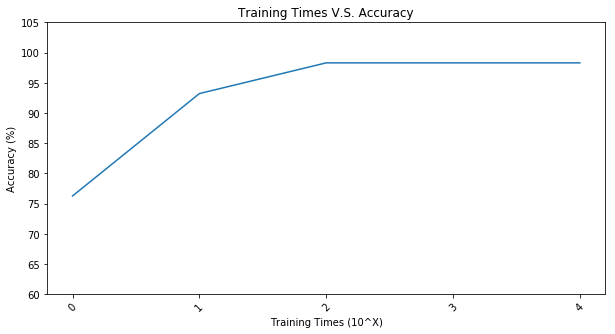

In [8]:
main()

## 結果 ##

進行多次實驗後發現，以葡萄酒的資料進行機器學習，多數的情況祇需給予 10^2 (=100) 次的訓練就可讓錯誤率收斂於區域最小值，之後再給予更多的訓練也不會影響其正確性，甚至有幾次的實驗結果是訓練越多正確率反而降低。

嘗試修改 Learning rate，在不同的訓練階段給予不同的 learning rate：第一次讀取資料時 learning rate = 10；前 10 次的訓練 learning rate = 1；前 100 次的訓練 learning rate = 0.1；第 100~1000 次的訓練 learning rate = 0.01；第 1000~10000 次的訓練 learning rate = 0.001，比較這樣的設定是否能更加逼進區域最佳解。但結果仍是 100 次訓練後就趨於穩定，不再有變化。

## 結論 ##

**可能是葡萄酒資料特徵明顯，類別 overlap 不明顯**，因此祇需訓練 100 次就可以得到不錯的結果，甚至祇是完整的跑完一次 training data 就能讓正確率高於 50%。比起完全隨機的亂猜，僅僅是訓練一次就能擁有比隨機亂猜更好的結果。

對 Neural Network 而言，重要的是各個輸入的 weight 值，為了得到更高的正確率，可以將 learning rate 調小一點，讓每次調整的步伐較小。

降低 Learning rate 雖然需要較多次的訓練才能達到區域最佳解，但是因為調整的步伐小，更有可能趨近區域最佳解，而不會在最佳解的兩旁震盪。祇要給予足夠的時間進行訓練，就能得到較準確的 weight 值，還是值得的投資。

但這次利用葡萄酒資料進行訓練時調整 learning rate 並沒有讓葡萄酒分類的正確率更高，其原因可能如前面所提到的：『葡萄酒資料特徵明顯，類別 overlap 不明顯』。在 overlap 不嚴重的情況下很容易將資料區分開，更趨近區域最佳解對於提高正確率並沒有幫助。